<a href="https://colab.research.google.com/github/pankaja0285/era_v1_session8_pankaja/blob/main/CiFAR_S8_gn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NOTE: If running from colab and you have uploaded the folder ERA-V1/era_v1_session8_pankaja then uncomment the two cells below and run before moving on to Install libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# %cd /gdrive/My\ Drive/ERA-V1/era_v1_session8_pankaja
current_path = "/content/drive/MyDrive/ERA_V1/era_v1_session8_pankaja"
current_path

'/content/drive/MyDrive/ERA_V1/era_v1_session8_pankaja'

In [3]:
import os
os.chdir(current_path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1bgfAWXoB_B4tVOjl87ebjLopidZ60n2W/era_v1_session8_pankaja'

### Target:
Apply:
 - Batch Normalization
 - Group Normalization
 - Linear Normalization


# Install libraries

In [4]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-d1lkdmyh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-d1lkdmyh
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=fcdab3eaddd9c5645d03ef5a08cbc3f2c22d8ecb8ded3c5ecf83815ccd41cd2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ytpxyyi/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


# Import Libraries

Let's first import all the necessary libraries

In [4]:
from __future__ import print_function
import numpy as np
from utils import plot_metrics, train, test, helper
from models import model
import torch
import torch.nn as nn
from pprint import pprint

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
from torchsummary import summary
from dataloader.load_data import CIFAR10DataLoader
from utils.engine import TriggerEngine

In [5]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1bgfAWXoB_B4tVOjl87ebjLopidZ60n2W/era_v1_session8_pankaja'

In [6]:
os.listdir()

['.gitignore',
 'README.md',
 'S8_sub.ipynb',
 'utils',
 'dataloader',
 'data_analysis',
 'models',
 'config',
 'data',
 'S8.ipynb',
 'runs']

## Load Configuration

In [7]:
config = helper.process_config("./config/config.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'args': {'cutout_prob': 0.5,
                                'horizontalflip_prob': 0.2,
                                'num_holes': 1,
                                'rotate_limit': 15,
                                'shiftscalerotate_prob': 0.25},
                       'type': 'CIFAR10Albumentation'},
 'data_loader': {'args': {'batch_size': 256,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'CIFAR10DataLoader'},
 'model': 'cifar10',
 'model_params

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [10]:
# GN - Model summary
model_gn = model.Net2().to(device)
summary(model_gn, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

## Download and view sample images

In [12]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
config['data_augmentation']['type'] = "CIFAR10Albumentation"
trigger_training=TriggerEngine(config)

Files already downloaded and verified
Files already downloaded and verified


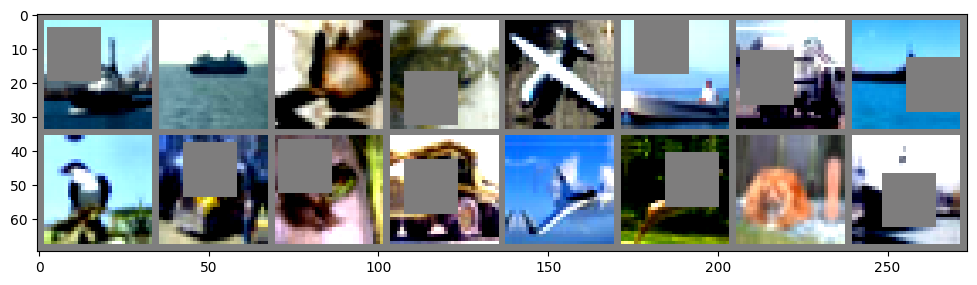

In [13]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader, test_loader = trigger_training.dataloader()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

In [14]:
torch.manual_seed(1)
# batch_size = 128
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

CUDA Available? True


### With Group Normalization

****Apply: Group Normalization****

#### Train & Test our Model with Group Normalization
 Let's train and test our model

In [28]:
exp_metrics_gn={}
config['model_params']['experiment_name'] = 'CiFar_Model_GN'
experiment_name_gn = config['model_params']['experiment_name']

config['model_params']['model_for'] = 'gn'
config['model_params']['model_name'] = 'CiFar_Model_GN'
config['model_params']['save_model'] = 'Y'
config['training_params']['epochs'] = 45

#Get dataloaders
train_loader, test_loader = trigger_training.dataloader()

trigger_training = TriggerEngine(config)

# trigger_training
(exp_metrics_gn[experiment_name_gn]) = trigger_training.run_experiment(model_gn, train_loader, test_loader)
trigger_training.save_experiment(model_gn, experiment_name_gn, path="saved_models")


Files already downloaded and verified
Files already downloaded and verified
Net2(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): ReLU()
    (2): GroupNorm(1, 32, eps=1e-05, affine=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(1, 32, eps=1e-05, affine=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(1, 32, eps=1e-05, affine=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(32, 32, kernel

Loss=1.8431028127670288 Batch_id=195 LR=0.00053 Accuracy=31.32: 100%|██████████| 196/196 [00:19<00:00, 10.08it/s]



Test set: Average loss: 0.0064, Accuracy: 4342/10000 (43.42%)

Epoch 2:


Loss=1.419831395149231 Batch_id=195 LR=0.00091 Accuracy=40.90: 100%|██████████| 196/196 [00:20<00:00,  9.69it/s]



Test set: Average loss: 0.0057, Accuracy: 4917/10000 (49.17%)

Epoch 3:


Loss=1.2827575206756592 Batch_id=195 LR=0.00152 Accuracy=46.42: 100%|██████████| 196/196 [00:19<00:00, 10.07it/s]



Test set: Average loss: 0.0050, Accuracy: 5533/10000 (55.33%)

Epoch 4:


Loss=1.5908825397491455 Batch_id=195 LR=0.00233 Accuracy=49.18: 100%|██████████| 196/196 [00:20<00:00,  9.46it/s]



Test set: Average loss: 0.0048, Accuracy: 5689/10000 (56.89%)

Epoch 5:


Loss=1.5414793491363525 Batch_id=195 LR=0.00330 Accuracy=51.36: 100%|██████████| 196/196 [00:19<00:00, 10.06it/s]



Test set: Average loss: 0.0045, Accuracy: 6032/10000 (60.32%)

Epoch 6:


Loss=1.3181852102279663 Batch_id=195 LR=0.00437 Accuracy=53.39: 100%|██████████| 196/196 [00:20<00:00,  9.55it/s]



Test set: Average loss: 0.0043, Accuracy: 6228/10000 (62.28%)

Epoch 7:


Loss=1.1866285800933838 Batch_id=195 LR=0.00548 Accuracy=55.23: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s]



Test set: Average loss: 0.0041, Accuracy: 6343/10000 (63.43%)

Epoch 8:


Loss=1.046785593032837 Batch_id=195 LR=0.00658 Accuracy=56.99: 100%|██████████| 196/196 [00:21<00:00,  9.29it/s]



Test set: Average loss: 0.0037, Accuracy: 6708/10000 (67.08%)

Epoch 9:


Loss=1.2627675533294678 Batch_id=195 LR=0.00760 Accuracy=58.27: 100%|██████████| 196/196 [00:21<00:00,  9.01it/s]



Test set: Average loss: 0.0038, Accuracy: 6674/10000 (66.74%)

Epoch 10:


Loss=1.0512067079544067 Batch_id=195 LR=0.00850 Accuracy=59.24: 100%|██████████| 196/196 [00:20<00:00,  9.58it/s]



Test set: Average loss: 0.0037, Accuracy: 6789/10000 (67.89%)

Epoch 11:


Loss=1.2959016561508179 Batch_id=195 LR=0.00921 Accuracy=60.59: 100%|██████████| 196/196 [00:19<00:00, 10.01it/s]



Test set: Average loss: 0.0037, Accuracy: 6775/10000 (67.75%)

Epoch 12:


Loss=1.0825961828231812 Batch_id=195 LR=0.00971 Accuracy=61.50: 100%|██████████| 196/196 [00:20<00:00,  9.48it/s]



Test set: Average loss: 0.0033, Accuracy: 7179/10000 (71.79%)

Epoch 13:


Loss=1.0470695495605469 Batch_id=195 LR=0.00997 Accuracy=62.78: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s]



Test set: Average loss: 0.0034, Accuracy: 7035/10000 (70.35%)

Epoch 14:


Loss=1.1778924465179443 Batch_id=195 LR=0.00999 Accuracy=62.99: 100%|██████████| 196/196 [00:20<00:00,  9.51it/s]



Test set: Average loss: 0.0033, Accuracy: 7183/10000 (71.83%)

Epoch 15:


Loss=1.2191716432571411 Batch_id=195 LR=0.00994 Accuracy=64.07: 100%|██████████| 196/196 [00:19<00:00, 10.06it/s]



Test set: Average loss: 0.0032, Accuracy: 7194/10000 (71.94%)

Epoch 16:


Loss=1.2949117422103882 Batch_id=195 LR=0.00984 Accuracy=64.17: 100%|██████████| 196/196 [00:21<00:00,  9.24it/s]



Test set: Average loss: 0.0031, Accuracy: 7258/10000 (72.58%)

Epoch 17:


Loss=0.922648549079895 Batch_id=195 LR=0.00970 Accuracy=64.81: 100%|██████████| 196/196 [00:19<00:00,  9.80it/s]



Test set: Average loss: 0.0030, Accuracy: 7458/10000 (74.58%)

Epoch 18:


Loss=1.2406028509140015 Batch_id=195 LR=0.00950 Accuracy=65.16: 100%|██████████| 196/196 [00:21<00:00,  9.05it/s]



Test set: Average loss: 0.0029, Accuracy: 7515/10000 (75.15%)

Epoch 19:


Loss=0.8963290452957153 Batch_id=195 LR=0.00927 Accuracy=65.82: 100%|██████████| 196/196 [00:20<00:00,  9.79it/s]



Test set: Average loss: 0.0034, Accuracy: 7088/10000 (70.88%)

Epoch 20:


Loss=0.9255116581916809 Batch_id=195 LR=0.00898 Accuracy=66.04: 100%|██████████| 196/196 [00:20<00:00,  9.54it/s]



Test set: Average loss: 0.0030, Accuracy: 7329/10000 (73.29%)

Epoch 21:


Loss=1.077091097831726 Batch_id=195 LR=0.00866 Accuracy=66.52: 100%|██████████| 196/196 [00:19<00:00, 10.28it/s]



Test set: Average loss: 0.0028, Accuracy: 7569/10000 (75.69%)

Epoch 22:


Loss=1.2078874111175537 Batch_id=195 LR=0.00831 Accuracy=67.04: 100%|██████████| 196/196 [00:20<00:00,  9.57it/s]



Test set: Average loss: 0.0030, Accuracy: 7437/10000 (74.37%)

Epoch 23:


Loss=0.9676254391670227 Batch_id=195 LR=0.00792 Accuracy=67.21: 100%|██████████| 196/196 [00:19<00:00,  9.96it/s]



Test set: Average loss: 0.0029, Accuracy: 7511/10000 (75.11%)

Epoch 24:


Loss=0.9049021601676941 Batch_id=195 LR=0.00750 Accuracy=67.67: 100%|██████████| 196/196 [00:21<00:00,  9.30it/s]



Test set: Average loss: 0.0028, Accuracy: 7593/10000 (75.93%)

Epoch 25:


Loss=0.8092157244682312 Batch_id=195 LR=0.00705 Accuracy=68.04: 100%|██████████| 196/196 [00:19<00:00, 10.00it/s]



Test set: Average loss: 0.0026, Accuracy: 7712/10000 (77.12%)

Epoch 26:


Loss=0.8955912590026855 Batch_id=195 LR=0.00659 Accuracy=68.05: 100%|██████████| 196/196 [00:23<00:00,  8.37it/s]



Test set: Average loss: 0.0026, Accuracy: 7766/10000 (77.66%)

Epoch 27:


Loss=0.9362722635269165 Batch_id=195 LR=0.00611 Accuracy=69.11: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]



Test set: Average loss: 0.0027, Accuracy: 7706/10000 (77.06%)

Epoch 28:


Loss=0.9483143091201782 Batch_id=195 LR=0.00562 Accuracy=68.75: 100%|██████████| 196/196 [00:21<00:00,  9.15it/s]



Test set: Average loss: 0.0026, Accuracy: 7763/10000 (77.63%)

Epoch 29:


Loss=0.8732709884643555 Batch_id=195 LR=0.00512 Accuracy=69.72: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]



Test set: Average loss: 0.0026, Accuracy: 7772/10000 (77.72%)

Epoch 30:


Loss=0.9743289947509766 Batch_id=195 LR=0.00462 Accuracy=70.28: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.0025, Accuracy: 7872/10000 (78.72%)

Epoch 31:


Loss=0.9712507128715515 Batch_id=195 LR=0.00413 Accuracy=70.73: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]



Test set: Average loss: 0.0026, Accuracy: 7760/10000 (77.60%)

Epoch 32:


Loss=0.9872740507125854 Batch_id=195 LR=0.00364 Accuracy=70.91: 100%|██████████| 196/196 [00:21<00:00,  9.07it/s]



Test set: Average loss: 0.0024, Accuracy: 7924/10000 (79.24%)

Epoch 33:


Loss=0.8706658482551575 Batch_id=195 LR=0.00317 Accuracy=71.47: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]



Test set: Average loss: 0.0024, Accuracy: 7943/10000 (79.43%)

Epoch 34:


Loss=0.922667384147644 Batch_id=195 LR=0.00272 Accuracy=71.50: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Average loss: 0.0024, Accuracy: 7998/10000 (79.98%)

Epoch 35:


Loss=0.6277269124984741 Batch_id=195 LR=0.00229 Accuracy=71.77: 100%|██████████| 196/196 [00:21<00:00,  9.12it/s]



Test set: Average loss: 0.0023, Accuracy: 8015/10000 (80.15%)

Epoch 36:


Loss=0.7133979797363281 Batch_id=195 LR=0.00188 Accuracy=72.87: 100%|██████████| 196/196 [00:20<00:00,  9.60it/s]



Test set: Average loss: 0.0023, Accuracy: 8040/10000 (80.40%)

Epoch 37:


Loss=0.7124579548835754 Batch_id=195 LR=0.00151 Accuracy=73.17: 100%|██████████| 196/196 [00:19<00:00, 10.01it/s]



Test set: Average loss: 0.0022, Accuracy: 8117/10000 (81.17%)

Epoch 38:


Loss=0.6415764093399048 Batch_id=195 LR=0.00117 Accuracy=73.76: 100%|██████████| 196/196 [00:19<00:00, 10.01it/s]



Test set: Average loss: 0.0022, Accuracy: 8141/10000 (81.41%)

Epoch 39:


Loss=0.618770956993103 Batch_id=195 LR=0.00087 Accuracy=74.16: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]



Test set: Average loss: 0.0022, Accuracy: 8179/10000 (81.79%)

Epoch 40:


Loss=0.8115620613098145 Batch_id=195 LR=0.00061 Accuracy=74.34: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s]



Test set: Average loss: 0.0022, Accuracy: 8147/10000 (81.47%)

Epoch 41:


Loss=0.9127342104911804 Batch_id=195 LR=0.00039 Accuracy=74.73: 100%|██████████| 196/196 [00:20<00:00,  9.67it/s]



Test set: Average loss: 0.0021, Accuracy: 8185/10000 (81.85%)

Epoch 42:


Loss=0.5301586389541626 Batch_id=195 LR=0.00022 Accuracy=74.99: 100%|██████████| 196/196 [00:19<00:00,  9.94it/s]



Test set: Average loss: 0.0021, Accuracy: 8195/10000 (81.95%)

Epoch 43:


Loss=0.7728577852249146 Batch_id=195 LR=0.00010 Accuracy=75.17: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]



Test set: Average loss: 0.0021, Accuracy: 8198/10000 (81.98%)

Epoch 44:


Loss=0.6420828104019165 Batch_id=195 LR=0.00002 Accuracy=75.41: 100%|██████████| 196/196 [00:19<00:00, 10.02it/s]



Test set: Average loss: 0.0021, Accuracy: 8216/10000 (82.16%)

Epoch 45:


Loss=0.6922322511672974 Batch_id=195 LR=0.00000 Accuracy=75.39: 100%|██████████| 196/196 [00:21<00:00,  9.14it/s]



Test set: Average loss: 0.0021, Accuracy: 8224/10000 (82.24%)

Saving the model for CiFar_Model_GN


In [29]:
# Model summary
trigger_training.model_summary(model_gn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

**Misclassification**

Total wrong predictions are 1776
Files already downloaded and verified


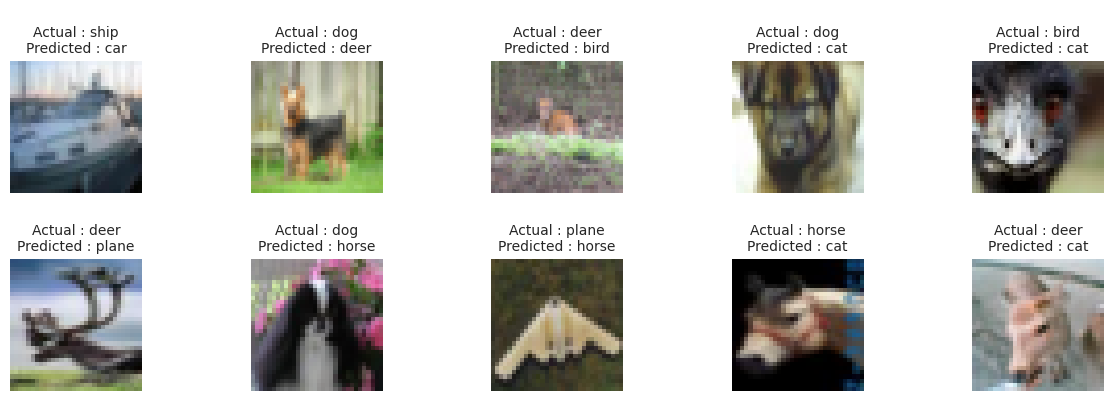

[(tensor([[[ 0.5190,  0.5190,  0.2174,  ...,  1.6302,  1.7731,  1.7890],
           [ 0.7095,  0.7412,  0.4079,  ...,  1.6937,  1.9160,  1.9160],
           [ 0.7730,  0.8047,  0.5031,  ...,  1.6620,  1.9795,  1.9001],
           ...,
           [-1.4971, -1.5130, -1.5765,  ..., -1.4018, -1.8463, -1.9257],
           [-1.6241, -1.5606, -1.5923,  ..., -1.6876, -1.9257, -1.9098],
           [-1.5447, -1.5130, -1.4812,  ..., -1.9098, -1.9257, -1.8781]],
  
          [[ 1.0799,  1.0316,  0.6934,  ...,  1.7402,  1.8691,  1.9013],
           [ 1.2410,  1.2249,  0.8544,  ...,  1.7564,  1.9818,  1.9979],
           [ 1.2571,  1.2410,  0.9027,  ...,  1.7080,  2.0302,  1.9496],
           ...,
           [-1.3360, -1.3521, -1.4165,  ..., -1.3360, -1.7709, -1.8675],
           [-1.4326, -1.3682, -1.4004,  ..., -1.6581, -1.8836, -1.8675],
           [-1.3199, -1.2877, -1.2555,  ..., -1.8836, -1.8997, -1.8514]],
  
          [[ 1.6211,  1.5611,  1.2013,  ...,  1.8010,  1.9359,  1.9809],
           

In [30]:
model_gn_mc = torch.load(f'./saved_models/{experiment_name_gn}.pt')
model_gn_mc.eval()
trigger_training.wrong_predictions(model_gn_mc, test_loader, num_img=10)

**Plot the train and test losses and accuracies for model_gn**

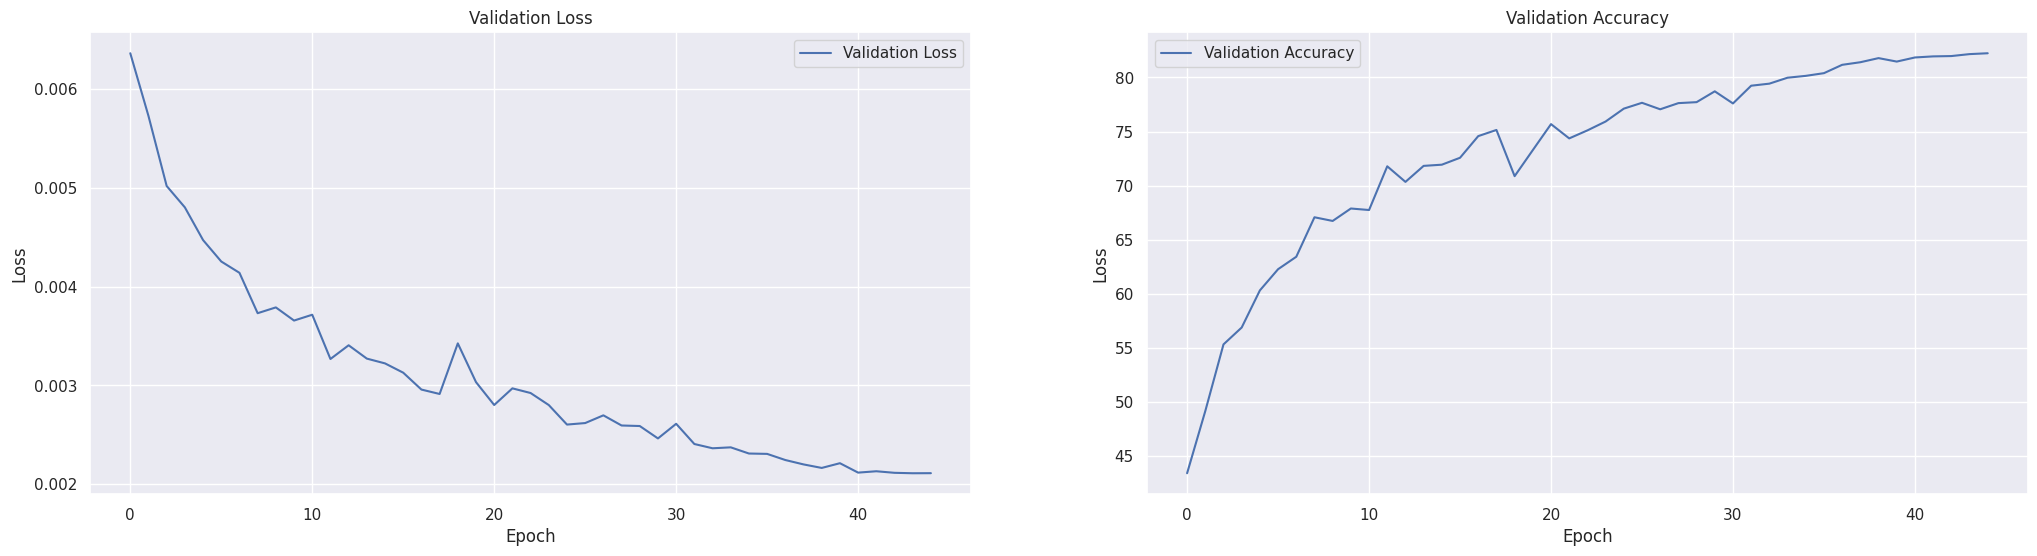

In [31]:
plot_metrics.plot_metrics(exp_metrics_gn[experiment_name_gn])
